In [1]:
import numpy as np 
import os, json
from os.path import isdir, join
from functools import cmp_to_key
import itertools
import matplotlib.pyplot as plt 

In [2]:
class score:
    def __init__(self):
        pass
    def get_course_score(self, courseInfo):
        return 0
    def get_schedule_score(self, scheduleInfo):
        return 0 
    def get_compact_score (self, scheduleInfo):
        return 0

In [10]:
mock = [
{# 201 Lec
    'name': 'CSCI201',
    'must have': True,
    'prefer':False,
    'unit': 4,
    'session':
    [
        {'ID': '30303', 'type':'Lec','time':'08:00am-09:20am, TTh', 'instructor':'Miller, Jeffrey', 'isFull':False ,'must have':False, 'prefer':True},
        {'ID': '30254', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29998', 'type':'Lec','time':'12:30pm-01:50pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29979', 'type':'Lec','time':'02:00pm-03:20pm, MW' , 'instructor':'Grujic, Olivera', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29993', 'type':'Lec','time':'10:00am-11:50am, MW' , 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        # 201 discussion
        {'ID': '30239', 'type':'Lab','time':'10:00am-11:50am, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30238', 'type':'Lab','time':'12:00pm-01:50pm, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30237', 'type':'Lab','time':'02:00pm-03:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30134', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':False, 'prefer':False},
        {'ID': '30385', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':True, 'prefer':False},
        {'ID': '30241', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30396', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29904', 'type':'Lab','time':'06:00pm-07:50pm, W', 'instructor':'', 'isFull':True,'must have':False, 'prefer':True},
        # 201 quiz
        {'ID': '30028', 'type':'Quiz', 'time':'', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 356 Lec 
{
    'name': 'CSCI356',
    'must have': True,
    'prefer':False,
    'unit':4,
    'session': 
    [
        {'ID': '29962', 'type':'Lec','time':'02:00pm-03:20pm, TTh', 'instructor':'Paolieri, Marco', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29912', 'type':'Lec','time':'09:30am-10:50am, TTh', 'instructor':'Goodney, Andrew', 'isFull':True ,'must have':False, 'prefer':True},
        # 356 Discussino 
        {'ID': '30239', 'type':'Dis','time':'02:00pm-03:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30124', 'type':'Dis','time':'10:00am-11:50am, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30239', 'type':'Dis','time':'12:00pm-01:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        # 356 Quiz 
        {'ID': '30285', 'type':'Quiz', 'time':'08:00pm-09:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 467 Lec
    
{
    'name':'CSCI467',
    'must have': True,
    'prefer': False,
    'unit':4,
    'session': 
    [
        {'ID': '30277', 'type':'Lec','time':'02:00pm-03:20pm, MW', 'instructor':'Rajati, Mohammad Reza', 'isFull':False ,'must have':False, 'prefer':False},
        # 467 Dis
        { 'ID': '30278', 'type':'Dis','time':'04:00pm-05:50pm, M', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':True},
        { 'ID': '30279', 'type':'Dis','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':False ,'must have':True, 'prefer':False}
    ]
},
# ENGR100
{
    'name':'ENGR100',
    'must have': False,
    'prefer': False,
    'unit':1,
    'session':
    [
        { 'ID': '28501', 'type':'Lec','time':'01:00pm-01:50pm, F', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':False}
    ]
},
    
# REL137
{
    'name':'REL137',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session':
    [
        {'ID':'60042', 'type':'Lec','time':'11:00am-12:20pm, TTH', 'instructor':'Jackson, Sherman', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60043', 'type':'Dis','time':'10:00am-10:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False}
    ]
}
]

In [11]:
from datetime import datetime
from collections import Counter
class greedySearch:
        
    def get_top_k(self, courseList, constrains=[]):
        courseList = self.__process_data(courseList, constrains) #
        return courseList
    
    def __process_data(self, courseList, constrains):
        for course in  courseList:
            self.__time_encoder(course) #  encode session time into array index 
        courseList = sorted(courseList, key = cmp_to_key(self.__cmp)) #  re-arrange the course list in priority order
        for course in  courseList:
            course['session'] = sorted(course['session'], key = cmp_to_key(self.__cmp)) # re-arrange session lists in priority order
            tempDict ={'Lec':[], 'Lab':[], 'Dis':[], 'Quiz':[]}
            for session in course['session']:
                tempDict[session['type']].append(session)
            course['grouped'] = tempDict
        return courseList
        
    '''
    encode textual time into array index, which later is used to check conflicts 
    '''
    def __time_encoder(self, course):
        for session in course['session']: 
            if session['time'] == '':
                session['timeNumeric'] = ()
                continue
            parsed = session['time'].split(',') # get time, day of week
            days = Counter(list(parsed[1]))
            daysNumeric = [] # convert day to numbers 
            if 'M' in days:
                daysNumeric.append(0)
            if 'T' in days and ('h' not in days or days['T']>days['h']):
                daysNumeric.append(1)
            if 'W' in days:
                daysNumeric.append(2)
            if 'T' in days and 'h' in days:
                daysNumeric.append(3)
            if 'F' in days:
                daysNumeric.append (4)

            time = parsed[0].split('-') # get start, end time
            startNumeric = [int(time[0].split(':')[0]), int(time[0].split(':')[1][:2])]
            endNumeric = [int(time[1].split(':')[0]), int(time[1].split(':')[1][:2])]
            if 'pm' in time[0] and '12' not in time[0]:
                startNumeric[0] +=12
            if 'pm' in time[1] and '12' not in time[1]:
                endNumeric[0] +=12
            startNumeric = int ((startNumeric[0]-7)*6 + (startNumeric[1]/10))# convert to index
            endNumeric = int ((endNumeric[0]-7)*6 + (endNumeric[1]/10)) # convert to index
            timeNumeric = []
            for i in daysNumeric:
                timeNumeric.append(((i*96) + startNumeric, (i*96) + endNumeric))
            session['timeNumeric'] = timeNumeric
    '''
    comparison logic: must have has the ultimate priority regardless of registration status (close)
    then isFull has the secondary priority. If a session is full, it is considered last
    then prefer has the third priority. If a session is preferred but not full, it will be place behind must-have but 
    before not preferred or closed session
    '''
    def __cmp(self, a,b):
        if a['must have'] :
            return -1 # a>b
        elif b['must have'] :
            return 1# b>a
        try:
            if a['isFull'] and not b['isFull']:
                return 1
            elif b['isFull'] and not a['isFull']:
                return -1
            elif b['isFull'] and a['isFull'] and b['prefer']:
                return 1
            elif b['isFull'] and a['isFull'] and a['prefer']:
                return -1
        except:
            pass
        
        if a['prefer'] and not b['prefer']:
            return -1
        elif b['prefer'] and not a['prefer']:
            return 1
        else:
            return 0 # same priority

In [12]:
model = greedySearch()

In [13]:
sortedL = model.get_top_k(mock)

In [14]:
for course in sortedL:
    print ('COURSE:', course['name'], ', must have:', course['must have'], ', prefer:', course['prefer'])
    for session in course['session']:
        print ('\t\tmust have:', session['must have'], ', prefer:', session['prefer'], ', isFull:', session['isFull'])

COURSE: CSCI467 , must have: True , prefer: False
		must have: True , prefer: False , isFull: False
		must have: False , prefer: True , isFull: False
		must have: False , prefer: False , isFull: False
COURSE: CSCI356 , must have: True , prefer: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: True , isFull: True
COURSE: CSCI201 , must have: True , prefer: False
		must have: True , prefer: False , isFull: True
		must have: False , prefer: True , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFull: False
		must have: False , prefer: False , isFu

In [45]:
import scipy
import scipy.stats as st
from scipy.special import gamma as gammaf
class scoreGenerator:
    def __init__(self, path, useML = False):
        with open (join(path, 'profInfoDB.json')) as handle: # read in prof info 
            self.profDB = json.load(handle)
        self.scores = np.array([score for score in self.profDB.values() if score !=[]])
        self.scores[:,0] = self.scores[:,0]/5 # normalize avg score 
        self.useML = useML
        if useML == False: # do not use naive bayesian algorithm to generate score
            self.__fit_distribution()
        else: # not implemented yet
            self.__train_naive_bayes() 

    def generate_course_score(self,course):
        for session in course['session']:
            if session['instructor'] == '':
                score, diffLevel, numRater = 0.5, 0.5, 0.5 # confidence = 0.5
            else:
                profName = session['instructor'].split(',')[1] + ' ' + session['instructor'].split(',')[0]
                try: # in case prof not found in the data base
                    profInfo = self.profDB[profName[1:]]
                    score = st.beta.cdf(profInfo[0]/5, self.scoreA, self.scoreB)
                    diffLevel = st.beta.cdf(profInfo[1], self.diffA, self.diffB)
                    numRater = st.expon.cdf(profInfo[2], self.numLoc, self.numScale)
                except:
                    score, diffLevel, numRater = 0.5, 0.5, 0.5 # confidence = 0.5
            if session['time'] == '' or session['time'] == 'TBA':
                time = 0.5
            else:
                startTime = session['time'].split('-')[0] # convert start time to int
                if 'pm' in startTime and '12' not in startTime:
                    startTime = 12 + int(startTime.split(':')[0])
                else:
                    startTime = int(startTime.split(':')[0])
            if startTime < 9: # WHO WANTS 8AM CLASS!!
                timeScore = 0.1
            elif startTime < 12: # regular morning session
                timeScore = 0.8
            elif startTime < 14: # power nap + lunch time
                timeScore = 0.3
            elif startTime < 17: # regular afternoon class
                timeScore = 0.8
            elif startTime < 18: # dinner time
                timeScore = 0.3
            else:
                timeScore = 0.5
            print (score, diffLevel, numRater, timeScore, session)
                
            
                
    def generate_schedule_score(self, schedule):
        pass
    
    
    def __fit_distribution(self):
        # the avg score satisfies Gamma distribution 
        scoreMean, scoreVar = np.mean(self.scores[:,0]), np.var(self.scores[:,0], ddof=1) 
        self.scoreA = scoreMean**2*(1-scoreMean)/scoreVar-scoreMean
        self.scoreB = self.scoreA*(1-scoreMean)/scoreMean
        # the difficulty level is also a Gamma distribution
        diffMean, diffVar = np.mean(self.scores[:,1]), np.var(self.scores[:,1], ddof=1) 
        self.diffA = diffMean**2*(1-diffMean)/diffVar-diffMean
        self.diffB = self.diffA*(1-diffMean)/diffMean
        # num of raters fits an exponential distribution
        self.numLoc, self.numScale = st.expon.fit(self.scores[:,2])
    def __train_naive_bayes(self):
        pass

In [46]:
model = scoreGenerator('.')
model.generate_course_score(mock[0])

0.5 0.5 0.5 0.8 {'ID': '30385', 'type': 'Lab', 'time': '04:00pm-05:50pm, T', 'instructor': '', 'isFull': True, 'must have': True, 'prefer': False, 'timeNumeric': [(150, 161)]}
0.22316782956034814 0.17048002373206436 0.990317435527043 0.1 {'ID': '30303', 'type': 'Lec', 'time': '08:00am-09:20am, TTh', 'instructor': 'Miller, Jeffrey', 'isFull': False, 'must have': False, 'prefer': True, 'timeNumeric': [(102, 110), (294, 302)]}
0.013289497557024434 0.032481895532807045 0.8608551364827451 0.8 {'ID': '30254', 'type': 'Lec', 'time': '11:00am-12:20pm, TTh', 'instructor': 'Grujic, Olivera', 'isFull': False, 'must have': False, 'prefer': False, 'timeNumeric': [(120, 128), (312, 320)]}
0.013289497557024434 0.032481895532807045 0.8608551364827451 0.3 {'ID': '29998', 'type': 'Lec', 'time': '12:30pm-01:50pm, TTh', 'instructor': 'Grujic, Olivera', 'isFull': False, 'must have': False, 'prefer': False, 'timeNumeric': [(129, 137), (321, 329)]}
0.013289497557024434 0.032481895532807045 0.8608551364827451

In [119]:
a,b,xx,yy = st.beta.fit((scores[:,0])/5) 

(array([0.04920184, 0.04373497, 0.15853925, 0.12573803, 0.28974415,
        0.39361469, 0.28974415, 0.59042204, 0.42641592, 0.57402143]),
 array([1.6 , 1.94, 2.28, 2.62, 2.96, 3.3 , 3.64, 3.98, 4.32, 4.66, 5.  ]),
 <a list of 10 Patch objects>)

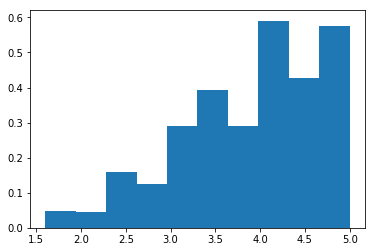

In [30]:
fitted=lambda x,a,b:gammaf(a+b)/gammaf(a)/gammaf(b)*x**(a-1)*(1-x)**(b-1) #pdf of beta


plt.hist(model.scores[:,0]*5, density = True)
